In [1]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate,MessagesPlaceholder
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import AnyMessage,add_messages
from typing import Annotated,List
from typing_extensions import TypedDict
from langgraph.graph.message import RemoveMessage
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3


from dotenv import load_dotenv
load_dotenv()



True

In [2]:
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
sqlite_conn = sqlite3.connect("chatgpt.sqlite", check_same_thread=False)
memory = SqliteSaver(sqlite_conn)

In [3]:
class State(TypedDict):
    messages : Annotated[List[AnyMessage], add_messages]

In [4]:
def filter_node(state: State):
    # Keep only the last 2 messages
    trimmed_msg = [RemoveMessage(id=m.id) for m in state["messages"][:-3]]
    return {"messages": trimmed_msg}

In [5]:
def chat_node(state: State):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system","you are an assistant"),
            MessagesPlaceholder("messages")
        ]
    )
    chain = prompt | llm
    response = [chain.invoke({"messages":state['messages']})]

    return {"messages":response }

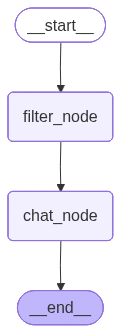

In [6]:
graph = StateGraph(State)

graph.add_node("chat_node",chat_node)
graph.add_node("filter_node",filter_node)

graph.add_edge(START, "filter_node")
graph.add_edge("filter_node", "chat_node")
graph.add_edge("chat_node",END)

workflow = graph.compile(checkpointer=memory)
workflow

In [7]:
config = {"configurable":{'thread_id':1}}

In [8]:
input_state = {"messages":['my name is sandesh']}
response_state = workflow.invoke(input_state, config=config)
response_state

{'messages': [HumanMessage(content='my name is sandesh', additional_kwargs={}, response_metadata={}, id='ce248de2-df2c-4861-b4b2-bee7c8d0ab01'),
  AIMessage(content="Okay, Sandesh! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--92ade4b5-d507-4d10-a680-13e795e9ad42-0', usage_metadata={'input_tokens': 9, 'output_tokens': 21, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}})]}

In [9]:
input_state = {"messages":['who am i']}
response_state = workflow.invoke(input_state, config=config)
response_state

{'messages': [HumanMessage(content='my name is sandesh', additional_kwargs={}, response_metadata={}, id='ce248de2-df2c-4861-b4b2-bee7c8d0ab01'),
  AIMessage(content="Okay, Sandesh! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--92ade4b5-d507-4d10-a680-13e795e9ad42-0', usage_metadata={'input_tokens': 9, 'output_tokens': 21, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='who am i', additional_kwargs={}, response_metadata={}, id='169d569e-a277-4cb8-b084-34113c47f3da'),
  AIMessage(content='You are Sandesh, as you told me.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f39a8796-039b-4f48-80c9-a841c73d91ab-0',

In [10]:
state = workflow.get_state(config=config)
print(state)

StateSnapshot(values={'messages': [HumanMessage(content='my name is sandesh', additional_kwargs={}, response_metadata={}, id='ce248de2-df2c-4861-b4b2-bee7c8d0ab01'), AIMessage(content="Okay, Sandesh! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--92ade4b5-d507-4d10-a680-13e795e9ad42-0', usage_metadata={'input_tokens': 9, 'output_tokens': 21, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='who am i', additional_kwargs={}, response_metadata={}, id='169d569e-a277-4cb8-b084-34113c47f3da'), AIMessage(content='You are Sandesh, as you told me.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f39a8796-039b-4f48-80c9-a

In [11]:
state = workflow.get_state(config={'configurable':{'thread_id':1,'checkpoint_id':'1f090562-512a-6016-8003-5fb58b00f307'}})
state

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f090562-512a-6016-8003-5fb58b00f307'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [12]:
state_history = workflow.get_state_history(config)
for state in state_history:
    print(state)

StateSnapshot(values={'messages': [HumanMessage(content='my name is sandesh', additional_kwargs={}, response_metadata={}, id='ce248de2-df2c-4861-b4b2-bee7c8d0ab01'), AIMessage(content="Okay, Sandesh! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--92ade4b5-d507-4d10-a680-13e795e9ad42-0', usage_metadata={'input_tokens': 9, 'output_tokens': 21, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='who am i', additional_kwargs={}, response_metadata={}, id='169d569e-a277-4cb8-b084-34113c47f3da'), AIMessage(content='You are Sandesh, as you told me.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f39a8796-039b-4f48-80c9-a

In [13]:
input_state = {"messages":['give me some life suggestions']}
response_state = workflow.invoke(input_state, config=config)
response_state

{'messages': [HumanMessage(content='who am i', additional_kwargs={}, response_metadata={}, id='169d569e-a277-4cb8-b084-34113c47f3da'),
  AIMessage(content='You are Sandesh, as you told me.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f39a8796-039b-4f48-80c9-a841c73d91ab-0', usage_metadata={'input_tokens': 32, 'output_tokens': 11, 'total_tokens': 43, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='give me some life suggestions', additional_kwargs={}, response_metadata={}, id='d4e804ef-668f-4d45-ae8d-c8f598b60687'),
  AIMessage(content="Okay, here are a few life suggestions, tailored to be generally helpful and encouraging:\n\n**Focusing on Well-being:**\n\n*   **Prioritize Sleep:** Aim for 7-9 hours of quality sleep each night. It impacts everything from mood and energy to physical health.\n*   **Nourish Your Body:** E